
### Climate Change and Sea Ice Extent

We want to answer the question: Has there been a decrease in the amount of ice in the last years?

For that we will use the sea ice extent measurements (in millions of square km) from the [National Snow & Ice Data Center](https://nsidc.org).

We perform the following processing steps:
1. Read and clean the data.
2. Normalize the Sea Ice Extent (SIE) data and visualize its temporal trend.
3. Compute the SIE temporal trend as a simple linear regression (OLS) and quantitatively evaluate it.
4. Estimate the sea ice extent for 2025.


### 1. Read and clean the data.
Load the monthly sea ice extent (SIE) monthly data provided in the file 'SeaIce.txt'. Note variables ``extent`` (SIE) and ``area`` should be greater or equal than zero. Detect possible outliers and clean the data.  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#your solution here
df = pd.read_csv("SeaIce.txt", sep="\s+") #We can use the regular expression \s+ to match any number of spaces as the file doesnt have a fixed structure
print(f"The DataFrame has {len(df)} items.")
df.head(5)

The DataFrame has 424 items.


,year,mo,data_type,region,extent,area
0,1979,1,Goddard,N,15.54,12.33
1,1980,1,Goddard,N,14.96,11.85
2,1981,1,Goddard,N,15.03,11.82
3,1982,1,Goddard,N,15.26,12.11
4,1983,1,Goddard,N,15.10,11.92


We can compute the correlations between variables. As we see below, extent and area are totally correlated and should give us the same information. Because of that, in this analysis we will focus on the variable ```extent```.

In [3]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,year,mo,extent,area
year,1.000000,-0.023981,0.056609,0.057043
mo,-0.023981,1.000000,-0.002868,-0.002849
extent,0.056609,-0.002868,1.000000,1.000000
area,0.057043,-0.002849,1.000000,1.000000


We can tweak the dataset so that the index represents the year-month combination. This is often done when working with time series to ease plotting and general analysis.

In [4]:
cuac = df.year.apply(str) + "-" + df.mo.apply(str)

In [5]:
pd.DatetimeIndex(pd.to_datetime(cuac, yearfirst = True)).strftime("%Y-%m")

Index(['1979-01', '1980-01', '1981-01', '1982-01', '1983-01', '1984-01',
       '1985-01', '1986-01', '1987-01', '1988-01',
       ...
       '2004-12', '2005-12', '2006-12', '2007-12', '2008-12', '2009-12',
       '2010-12', '2011-12', '2012-12', '2013-12'],
      dtype='object', length=424)

In [6]:
df2 = df.copy()
df2.index = pd.DatetimeIndex(pd.to_datetime(cuac, yearfirst = True)).strftime("%Y-%m")
df2.head()

,year,mo,data_type,region,extent,area
1979-01,1979,1,Goddard,N,15.54,12.33
1980-01,1980,1,Goddard,N,14.96,11.85
1981-01,1981,1,Goddard,N,15.03,11.82
1982-01,1982,1,Goddard,N,15.26,12.11
1983-01,1983,1,Goddard,N,15.10,11.92


In [7]:
df2_s = df2.sort_index()
df2_s.head()

,year,mo,data_type,region,extent,area
1978-11,1978,11,Goddard,N,12.01,8.97
1978-12,1978,12,Goddard,N,14.12,10.85
1979-01,1979,1,Goddard,N,15.54,12.33
1979-02,1979,2,Goddard,N,16.31,13.11
1979-03,1979,3,Goddard,N,16.45,13.13


We check for NaN values but none were found within the data.

In [8]:
df2_s.isna().sum()

year         0
mo           0
data_type    0
region       0
extent       0
area         0
dtype: int64

Finally, we get ride of clearly wrong values. This is the last step in the data cleaning process.

In [9]:
df3 = df2_s[(df2_s["extent"] >= 0) | (df2_s["area"] >= 0)]
print(f"We have detected and deleted {len(df2_s) - len(df3)} incorrect entries.\nActual entries: {len(df3)}.")
df3.head()

We have detected and deleted 2 incorrect entries.
Actual entries: 422.


,year,mo,data_type,region,extent,area
1978-11,1978,11,Goddard,N,12.01,8.97
1978-12,1978,12,Goddard,N,14.12,10.85
1979-01,1979,1,Goddard,N,15.54,12.33
1979-02,1979,2,Goddard,N,16.31,13.11
1979-03,1979,3,Goddard,N,16.45,13.13


We don't do any outlier cleaning because, as we can see from the figures below, the data looks overall correct. If we did consider outliers the datapoints lying 2/3$\sigma$ away from the mean, we might miss classify some points which are that far because of the apparent change in time of the serie. One thing we could do is getting rid of the values which don't correspond to full year measurements. There are 4 values of this kind. By doing so we would end up with a closed time serie composed of only full measure cycles.

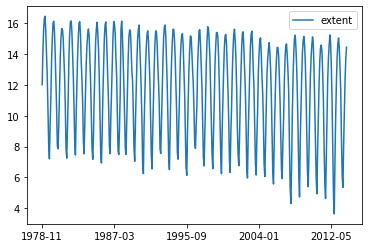

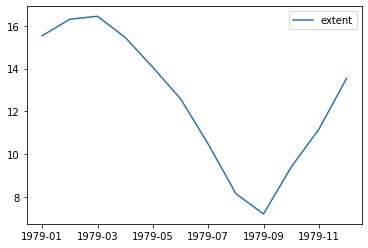

In [10]:
#your response here
df3.plot(y = "extent")

df3.loc["1979-01":"1979-12"].plot(y = "extent")

plt.show()

### 2. Normalize the SIE data and visualize its temporal trend.

Visualize there is a monthly dependence of SIE, explore the linear relationship using ``lmplot``.
Compute the mean and variance of SIE for each month.

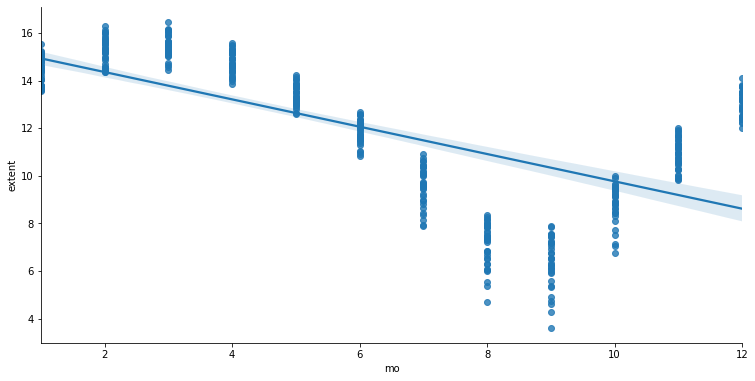

In [11]:
sns.lmplot(x="mo", y="extent", data = df3, height=5.2, aspect=2)
plt.show()

By using the ```.groupby()``` method we can group the DataFrame by month and calculate its mean and variance with the ```.mean()``` and ```.var()``` methods. 

*If we wanted to, we could compute the standard deviation as well by using the ```.std()``` method.*

In [12]:
m_mean = df3.groupby(["mo"]).mean()
m_mean

,year,extent,area
mo,,,
1,1996.742857,14.479429,12.118571
2,1996.500000,15.298889,12.920833
3,1996.000000,15.491714,13.076857
4,1996.000000,14.766000,12.426286
5,1996.000000,13.396000,11.013714
6,1996.000000,11.860000,9.015143
7,1996.000000,9.601143,6.237714
8,1996.000000,7.122286,4.530571
9,1996.000000,6.404857,4.246286


In [13]:
m_var = df3.groupby(["mo"]).var()
m_var

,year,extent,area
mo,,,
1,112.078992,0.304906,0.187330
2,111.000000,0.295804,0.193191
3,105.000000,0.237209,0.140269
4,105.000000,0.215378,0.109648
5,105.000000,0.189901,0.097942
6,105.000000,0.247918,0.255561
7,105.000000,0.679175,0.393130
8,105.000000,0.824577,0.515723
9,105.000000,1.143902,0.622165


In [14]:
m_std = df3.groupby(["mo"]).std()
m_std

,year,extent,area
mo,,,
1,10.586737,0.552183,0.432817
2,10.535654,0.543879,0.439535
3,10.246951,0.487041,0.374525
4,10.246951,0.464088,0.331131
5,10.246951,0.435777,0.312956
6,10.246951,0.497913,0.505530
7,10.246951,0.824121,0.627001
8,10.246951,0.908062,0.718139
9,10.246951,1.069534,0.788774


Normalize the SIE data: subtract the monthly mean and then convert to percent difference by dividing by the 1981-2013 average and then multiplying by 100.

In [15]:
#your response here
df3_norm = df3.copy() #We make a copy so that we dont break the original dataframe
df3_norm.head()

,year,mo,data_type,region,extent,area
1978-11,1978,11,Goddard,N,12.01,8.97
1978-12,1978,12,Goddard,N,14.12,10.85
1979-01,1979,1,Goddard,N,15.54,12.33
1979-02,1979,2,Goddard,N,16.31,13.11
1979-03,1979,3,Goddard,N,16.45,13.13


In [16]:
mean_81_13 = df3[np.bitwise_and(df3["year"] >= 1981, df3["year"] <= 2013)].mean(axis = 0)["extent"]
mean_81_13

11.714365482233502

In [17]:
df3_norm["extent"] = df3_norm[["mo", "extent"]].apply(lambda x: (x.extent - m_mean.loc[x.mo]["extent"]) / mean_81_13 * 100, axis = 1)
df3_norm.head()

,year,mo,data_type,region,extent,area
1978-11,1978,11,Goddard,N,8.923042,8.97
1978-12,1978,12,Goddard,N,9.053597,10.85
1979-01,1979,1,Goddard,N,9.053597,12.33
1979-02,1979,2,Goddard,N,8.631378,13.11
1979-03,1979,3,Goddard,N,8.180432,13.13


Visualize the trend of SIE per year considering:1) all months, 2) January, 3) August

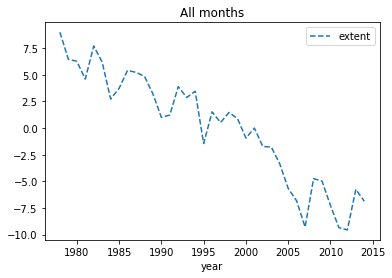

In [18]:
df3_norm.groupby(by = "year").mean().plot(y="extent", style = '--')
plt.title("All months")
plt.show()

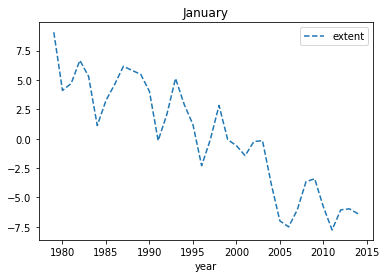

In [19]:
df3_norm[df3_norm["mo"] == 1].groupby(by = "year").mean().plot(y = "extent", style = "--")
plt.title("January")
plt.show()

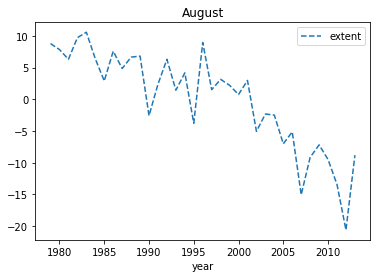

In [20]:
df3_norm[df3_norm["mo"] == 8].groupby(by = "year").mean().plot(y = "extent", style = "--")
plt.title("August")
plt.show()

Calculate the Pearson correlation coefficient and the p-value for testing non-correlation of the SIE temporal trend (consider all months). Is it significant?

We can easily calculate the Pearson correlation coefficient directly from our DataFrame with the method ```.corr()```:

In [21]:
#your response here
corr = df3_norm.corr()
corr.style.background_gradient(cmap='coolwarm')

,year,mo,extent,area
year,1.000000,-0.023795,-0.818350,-0.067186
mo,-0.023795,1.000000,0.000000,-0.620291
extent,-0.818350,0.000000,1.000000,0.130839
area,-0.067186,-0.620291,0.130839,1.000000


Note that now, the Pearson correlation between ```extent``` and ```area``` has changed. That's because we have normalized the ```extent``` but not the ```area``` in a non-linear way. This is important because we have to take into account which transformations have we made to the date to interpret the correlations.

If we want to calculate the p-value we can make use of the library ```scipy```:

In [22]:
from scipy.stats import pearsonr

As we want to test the non-correlation of the SIE temporal trend, we start by assuming there's no temporal trend ($H_{0}$ hypothesis) and check wether it holds or not by calculating the Pearson correlation coefficient. The p-value obtained from this test indicates the probability of an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets. By calculating the p-value, if it lies below 0.05, we could argue it was not due by chance and that the SIE has some temporal trend ($H_{A}$ hypothesis).

In [23]:
r, p = pearsonr(df3_norm.year, df3_norm.extent)
print(f"Pearson R = {r} / p-value = {p}.")

Pearson R = -0.8183500709897178 / p-value = 4.4492318168703415e-103.


As we saw obtained, the p-value is very very small $\mathcal{O}(-103)$ and so the result is statistically significant and the null hypothesis wouldn't hold. It looks like the SIE actually has some temporal trend.

This shouldn't be a really suprising fact, as we can see that it changes seasonally by looking at the figures above.

Another way of testing this dependence could be a t-test. This is a two-sided test for the null hypothesis that 2 independent samples have identical averages. It's p-value gives us the chance of obtaining that difference in mean by random facts when considering true de $H_{0}$ hypothesis.

This test may have 2 implementations:
1. We can test for two different years in the series. This would give us an indicator of how possible would be to obtain both series if there was no correlation.
2. We can create a synthetic dataset containing only the maximum extent value and test it against our dataset. This could make sense under the null hypothesis, because if there was no temporal trend, the extent would not change and would remain constant at its maximum value

Lets proceed with both calculations:

In [24]:
from scipy.stats import ttest_ind

In [25]:
ttest_ind(df3_norm[df3_norm["year"] == 1980].extent, df3_norm[df3_norm["year"] == 2010].extent)

Ttest_indResult(statistic=11.03688189156308, pvalue=1.9476519029808805e-10)

In [26]:
ttest_ind([df3_norm["extent"].max()]*len(df3_norm), df3_norm.extent, equal_var = False)

Ttest_indResult(statistic=45.52089224674559, pvalue=1.0599313127173104e-164)

As we can see, both test yield the same results as before. The observations are **very** unlikely to be due to chance under the $H_{0}$ hypothesis and there's statistically significant observations supporting that there is temporal correlation between the extent and the time.

### 3. Compute the trend as a simple linear regression (OLS) and quantitatively evaluate it.

Provide the estimated parameters for the linear regression. 
Evaluate the quality of fit quantitatively and graphically.

In [27]:
import statsmodels.api as sm

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [28]:
#your solution here
y = df3_norm.groupby(by = "year").mean().extent  # response
X = df3_norm.groupby(by = "year").mean().index  # predictor
# Note: no constant is added by the model unless you are using formulas (!!)
X = sm.add_constant(X)  # Adds a constant term to the predictor
#X.head()

In [29]:
est = sm.OLS(y, X)
est = est.fit()

In [30]:
print(est.params)
print('MSE: ',est.mse_total)
print('R_squared: ',est.rsquared)

const    905.193902
x1        -0.453469
dtype: float64
MSE:  27.19604144176221
R_squared:  0.8859166406785122


The OLS tells us that the corelation between both variables is negative (x1 < 0), or in other words, that the SIE gets reduced by each passing year. A not so bad thing to note is that it's being reduced slowly, as the slope of the curve is relatively small. The R$^2$ of the fit is quite close to 1 and so it can be considered a good fit.

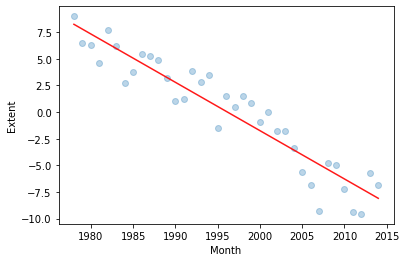

In [31]:
# We pick 100 hundred points equally spaced from the min to the max 
X_prime = np.linspace(df3_norm.groupby(by = "year").mean().index.min(), df3_norm.groupby(by = "year").mean().index.max(), 100)
X_prime = sm.add_constant(X_prime) # add constant as we did before 
# Now we calculate the predicted values 
y_hat = est.predict(X_prime) 
plt.scatter(df3_norm.groupby(by = "year").mean().index, y, alpha=0.3) 
# Plot the raw data 
plt.xlabel("Month") 
plt.ylabel("Extent") 
plt.plot(X_prime[:, 1], y_hat, 'r', alpha=0.9) # Add the regression line, colored in red 
plt.show()

In the figure above the negative tendency can be clearly observed. Actually, it's interesting to see that the last years have more dispersion towards lower values, indicating that the augment in the global temperature is playing a role in the reduction of the SIE.

In [32]:
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 extent   R-squared:                       0.886
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     271.8
Date:                Sat, 07 Nov 2020   Prob (F-statistic):           4.50e-18
Time:                        16:24:53   Log-Likelihood:                -72.940
No. Observations:                  37   AIC:                             149.9
Df Residuals:                      35   BIC:                             153.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        905.1939     54.903     16.487      0.000     793.735    1016.653
x1            -0.4535      0.028    -16.486      0.000      -0.509      -0.398
==============================================================================
Omnibus:                        3.124   Durbin-Watson:                   1.343
Prob(Omnibus):                  0.210   Jarque-Bera (JB):                2.628
Skew:                          -0.544   Prob(JB):                        0.269
Kurtosis:                       2.277   Cond. No.                     3.73e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.73e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 4. Estimate the sea ice extent for 2025

 Is there a negative trend in the evolution of sea ice extent over recent years? 

In [33]:
#your solution here

In [34]:
year = np.array([1, 2025])
pred = est.predict(year.reshape(1, -1))
print(f"Estimated SIE for 2025: {pred}.")

Estimated SIE for 2025: [-13.08005373].


Now we have to undo the normalization:

We know how to undo the normalization for the monthly extent:
$$ monthlyExtent =  monthlyExtent_{i}^{*} \frac{mean_{81-13}}{100} + mMean_{i} $$

And, as we calculated the yearly extent as the mean of the montly extent, the un-normalized value should be calculated as follows:
$$ yearlyExtent = \frac{1}{12}\sum_{i}^{12} monthlyExtent = \frac{1}{12}\sum_{i}^{12} monthlyExtent_{i}^{*} \frac{mean_{81-13}}{100} + mMean_{i} = \frac{1}{12}\sum_{i}^{12} monthlyExtent^{*}\frac{mean_{81-13}}{100} + \frac{1}{12}\sum_{i}^{12} mMean_{i} = yearlyExtent^{*}\frac{mean_{81-13}}{100} +  Mean(mMean_{i})$$

Which can be implemented as follows:

```pred_real = pred * mean_81_13 / 100 + m_mean.mean()```

In [35]:
pred_real = pred * mean_81_13 / 100 + m_mean.mean()["extent"]
print(f"The estimated SIE for 2025 is {pred_real[0]:.2f} (millions of km^2).")

The estimated SIE for 2025 is 10.24 (millions of km^2).
